**Review**
	  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a pretty good job overall, but there are a couple of problems that need to be fixed before the project can be accepted. Good luck!

<div class="alert alert-info">
<b>Student's comment v.1:</b>
    
  Hello Dmitry, I appreciate your input - exactly the parts I was missing.  
  I've addressed all of your notes, it makes much more sense for me now,  
  thank you!
    
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
You're very welcome! Glad if I could help clear something up!
    
The problems are corrected now, so the project is accepted. Keep up the good work on the next sprint! :)
	  
</div>

# Taxi orders - time series analysis

Sweet Lift Taxi company has collected historical data on taxi orders at airports.  
To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour.  
Build a model for such a prediction.

\* The RMSE metric on the test set should not be more than 48.

## Table of contents
- [Libraries](#Libraries)
- [Analysis](#Analysis)
    - [Trends and Seasonality](#Trends-and-Seasonality)
    - [Conclusions](#Analysis-conclusions)
- [Forecast](#Forecast)
    - [Baseline](#Baseline)
    - [Models - Preliminary run](#Models---Preliminary-run)
    - [Hyperparameters tuning](#Hyperparameters-tuning)
    - [Conclusions](#Forecast-conclusions)

## Libraries

In [1]:
!pip install -q --user --upgrade pandas matplotlib statsmodels sklearn scikit-learn lightgbm xgboost catboost

In [2]:
import os
from pprint import pprint
from IPython.display import display, Markdown

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_validate, TimeSeriesSplit, HalvingGridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # 'png'
plt.rcParams['figure.figsize'] = (13, 7)

In [4]:
random_state = 42

## Analysis

In [5]:
def find_file(filename):
    """Returns file path under /datasets directory, if exists, otherwise uses local dir"""
    
    filepath = f'/datasets/{filename}'
    if not os.path.isfile(filepath):
        filepath = filename
        
    return filepath

In [6]:
filename = find_file('taxi.csv')

In [7]:
!du -h "$filename"
!wc -l "$filename"
!head -n2 "$filename"

588K	taxi.csv
   26497 taxi.csv
datetime,num_orders
2018-03-01 00:00:00,9


In [8]:
df = pd.read_csv(filename, parse_dates=['datetime'], index_col='datetime')

In [9]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [11]:
df.isna().sum()

num_orders    0
dtype: int64

There are no missing values.

In [12]:
df.index.duplicated().sum()

0

There are no duplicated values.

Although the indices look sorted, we will explicitly sort them in-place to guarantee the correct order.

In [13]:
df.sort_index(inplace=True)

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Good idea!
	  
</div>

In [14]:
df.index.to_series().describe(datetime_is_numeric=True)

count                  26496
mean     2018-05-31 23:55:00
min      2018-03-01 00:00:00
25%      2018-04-15 23:57:30
50%      2018-05-31 23:55:00
75%      2018-07-16 23:52:30
max      2018-08-31 23:50:00
Name: datetime, dtype: object

In [15]:
df.index.to_series().diff().mean().components

Components(days=0, hours=0, minutes=10, seconds=0, milliseconds=0, microseconds=0, nanoseconds=0)

Data starts at 2018-03-01 and end at 2018-08-31, inclusive (half a year).  
The resolution of the data is of 10 minutes (10 minute intervals).

In [16]:
def analyze_rolling(span, resolution, rolling, res_agg='sum'):
    
    series = span.resample(resolution).apply(res_agg).squeeze()
    rolling = series.rolling(rolling)
    
    pd.concat([
        series,
        rolling.mean().rename('mean'),
        rolling.std().rename('std'),
    ], axis=1).plot()
    
    plt.title(f'Rolling mean / std (window={rolling.window})')

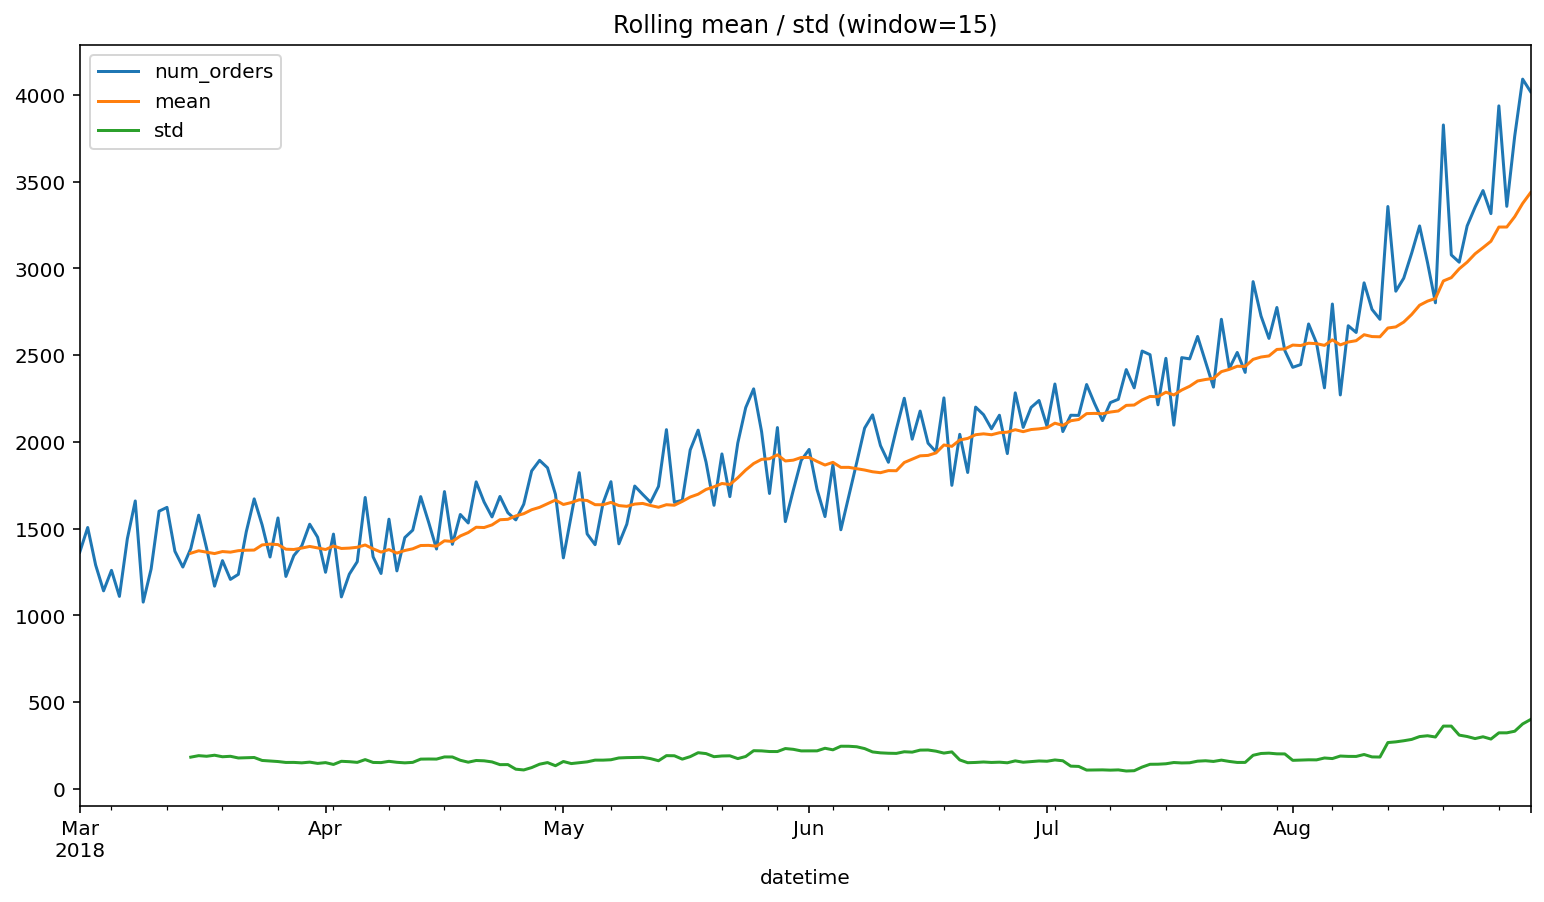

In [17]:
analyze_rolling(df['2018-03':'2018-08'], '1D', rolling=15)

We can see a steady increase of the amount of oorders throughout the months.  

This time series is non-stationary (mean and std change considerably),  
which means it's going to be harder for us to forecast.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Yep, that's true!
	  
</div>

### Trends and Seasonality

We will resample the data to a day resolution,  
and then look more closely at the seasonality analysis for half a year, a month and a week chunks.

In [18]:
components = seasonal_decompose(df.resample('1D').sum())

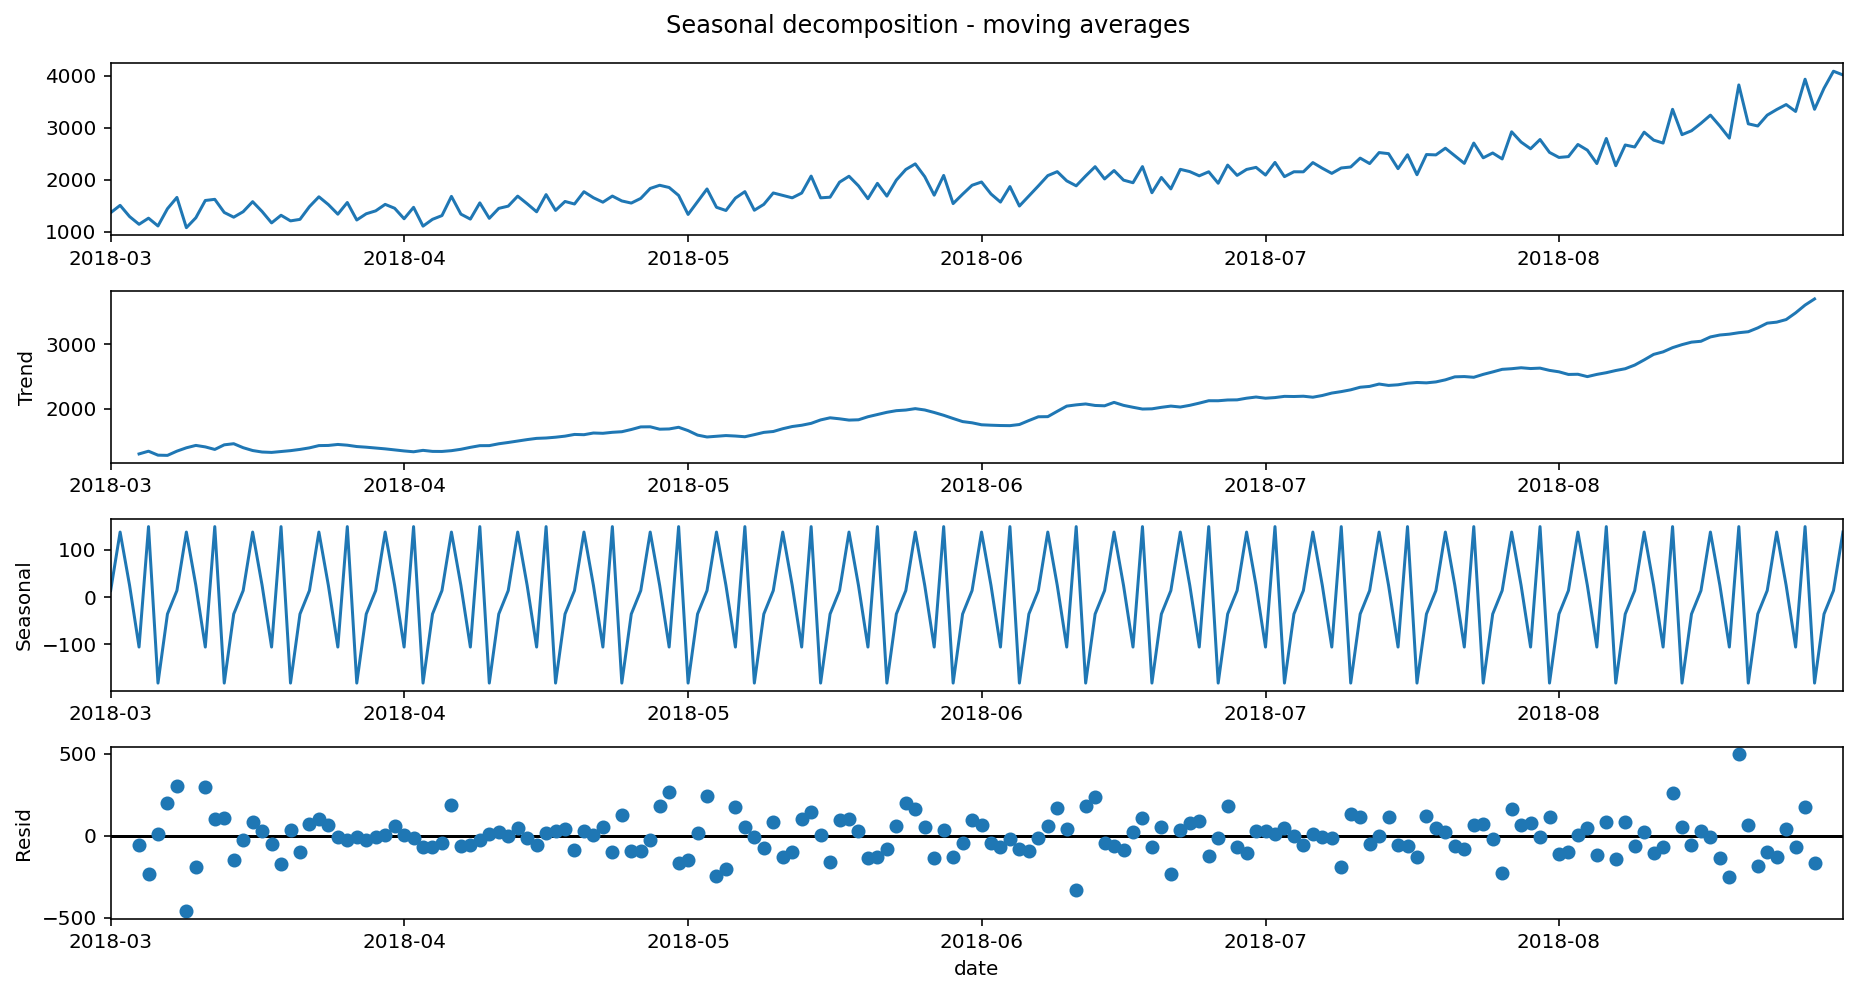

In [19]:
components.plot();
plt.suptitle('Seasonal decomposition - moving averages')
plt.xlabel('date')
plt.tight_layout();

There's a clear trend of growth.  
We can also see the seasonality is there, seems to be on a weekly basis.  
Zooming in to inspect in detail.

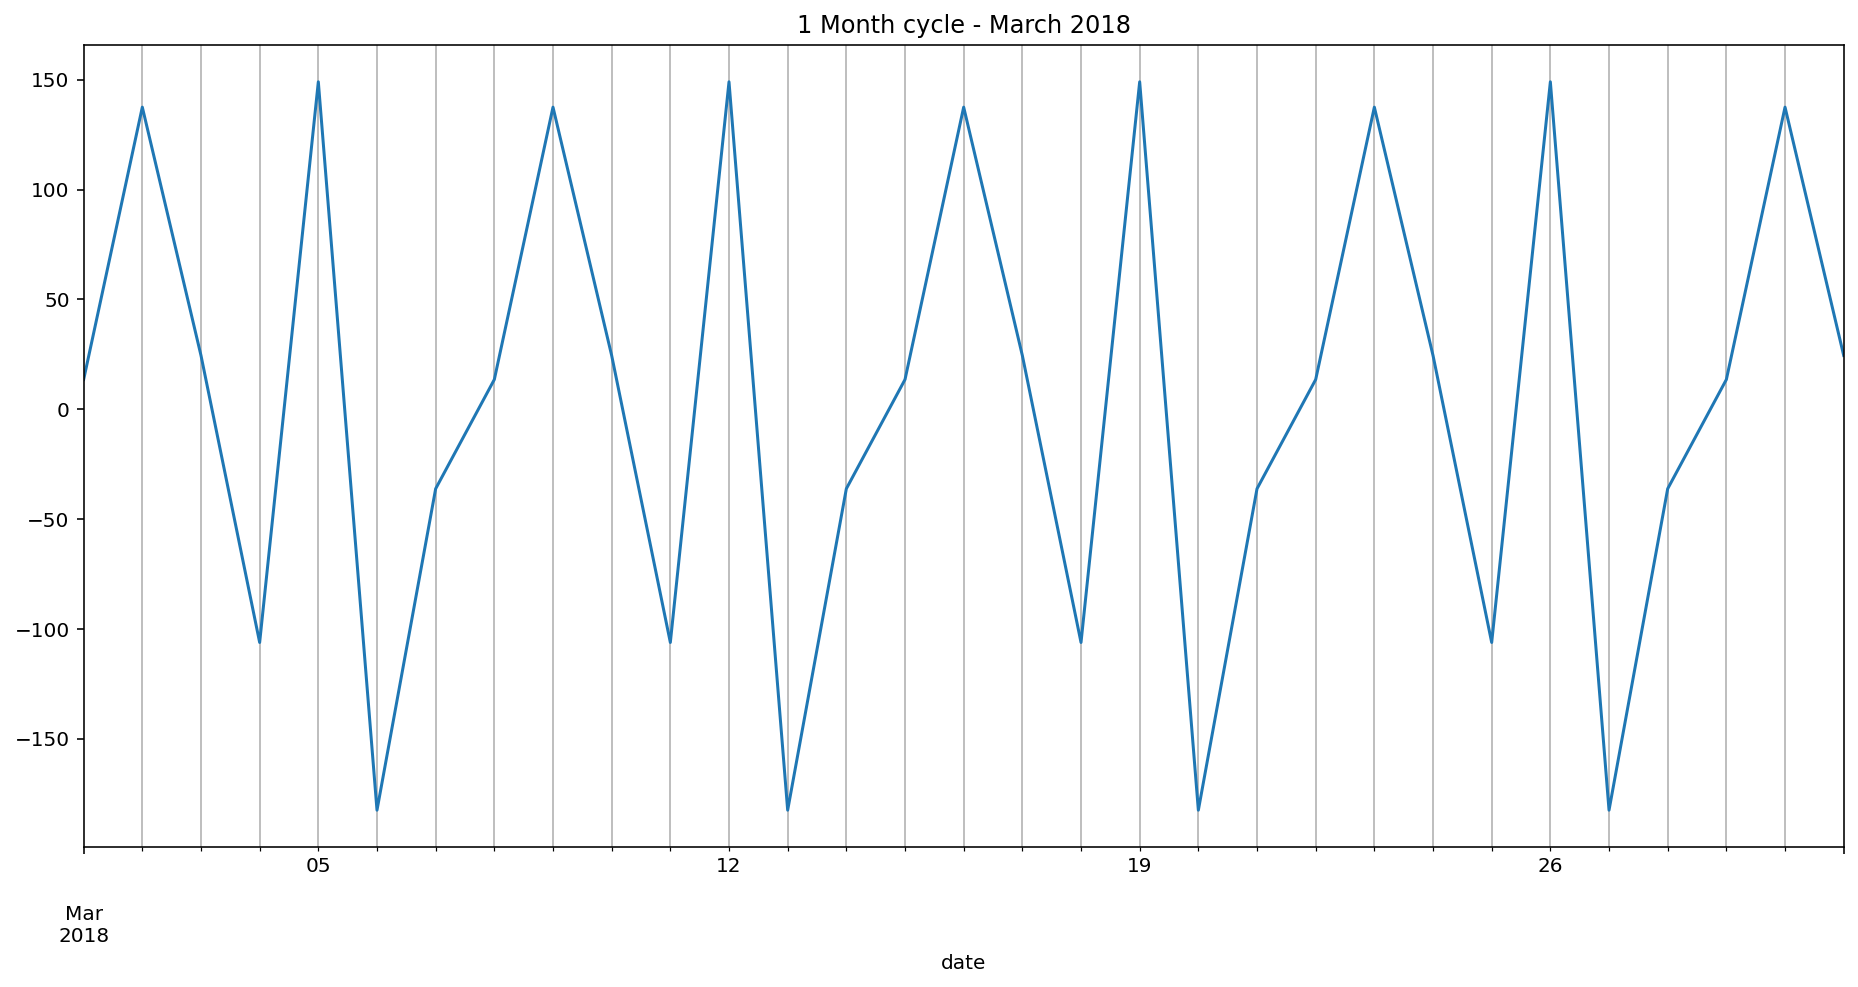

In [20]:
ax = components.seasonal['2018-03'].plot(title='1 Month cycle - March 2018')
ax.grid(True, which='minor')
plt.xlabel('date')
plt.tight_layout();

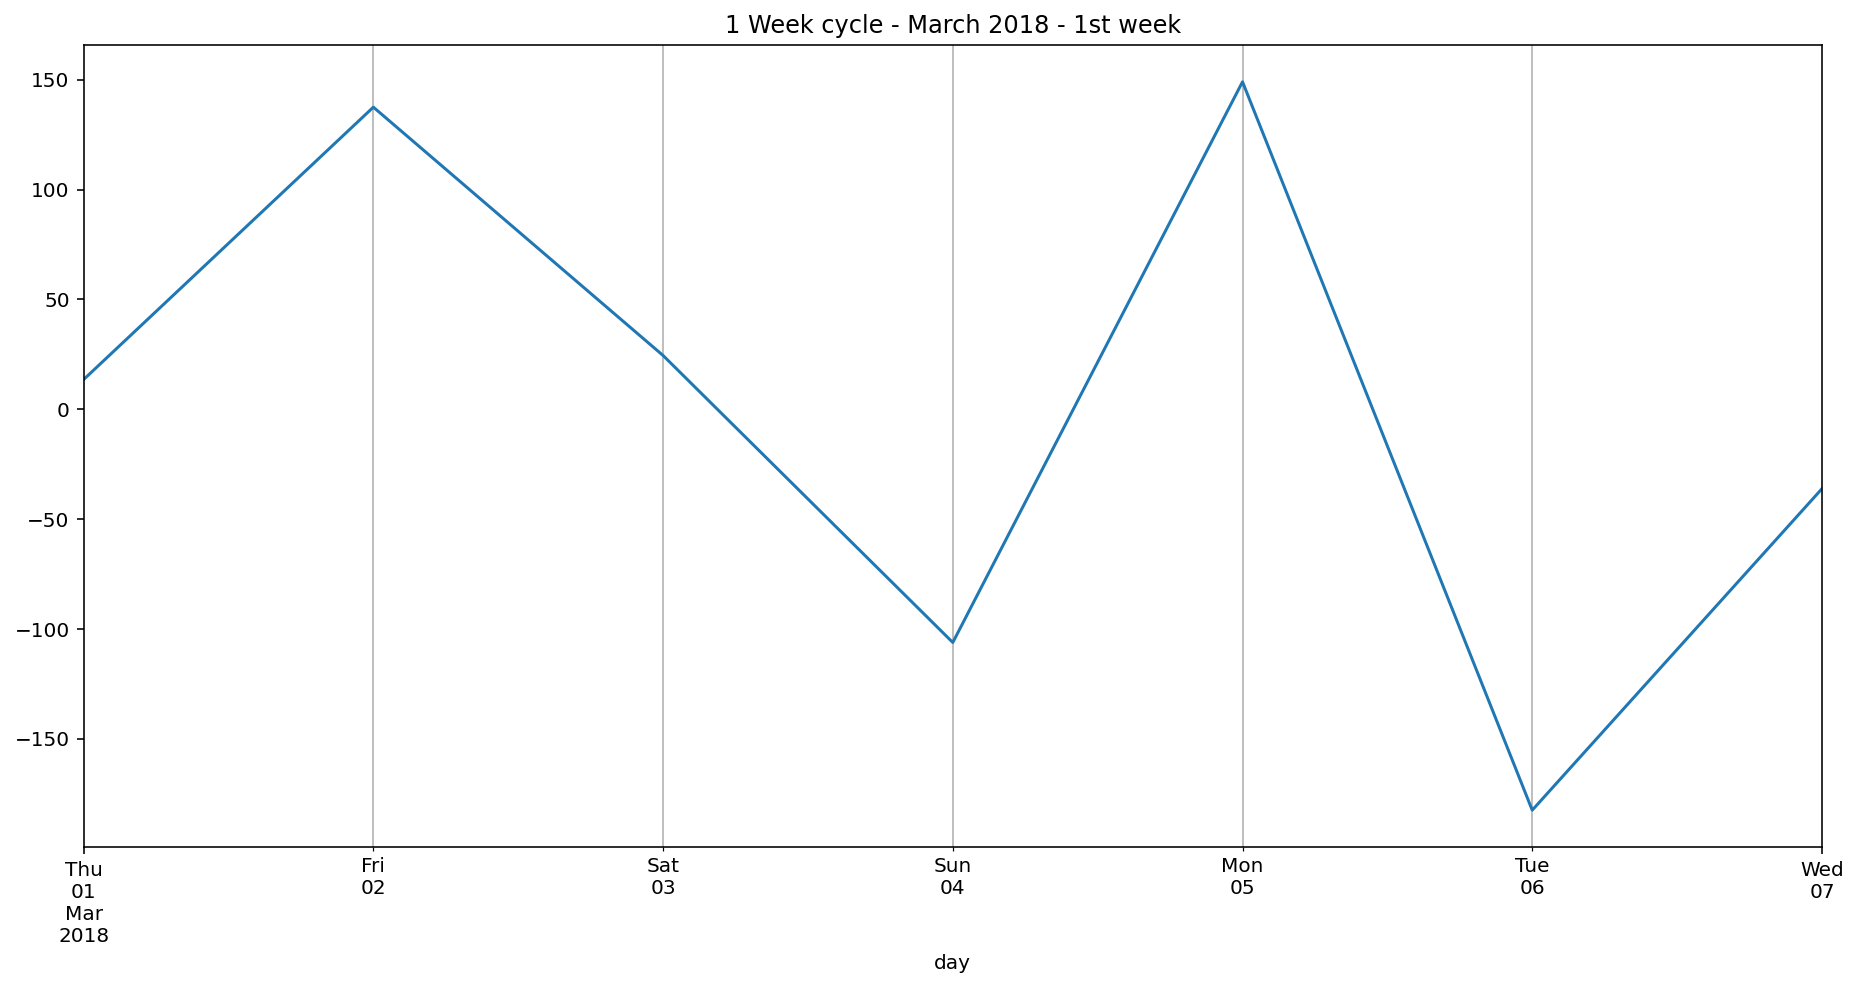

In [21]:
week_res = components.seasonal['2018-03-01':'2018-03-07']
ax = week_res.plot(title='1 Week cycle - March 2018 - 1st week');
ax.grid(True, which='minor')

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([week_res.index[0].strftime('%a\n%d\n%b\n%Y'),
                    week_res.index[-1].strftime('%a\n%d')])

ax.set_xticks(ax.get_xticks(minor=True), minor=True)
ax.set_xticklabels(week_res.index[1:-1].strftime('%a\n%d'), minor=True)

plt.xlabel('day')
plt.tight_layout()

There are 2 noticeable peaks: Friday and Monday.  
The weakest part of the week is on Tuesday.

To look at a day of data,  
we will have to resample the data to an hour resolution - and then zoom in on a single day.

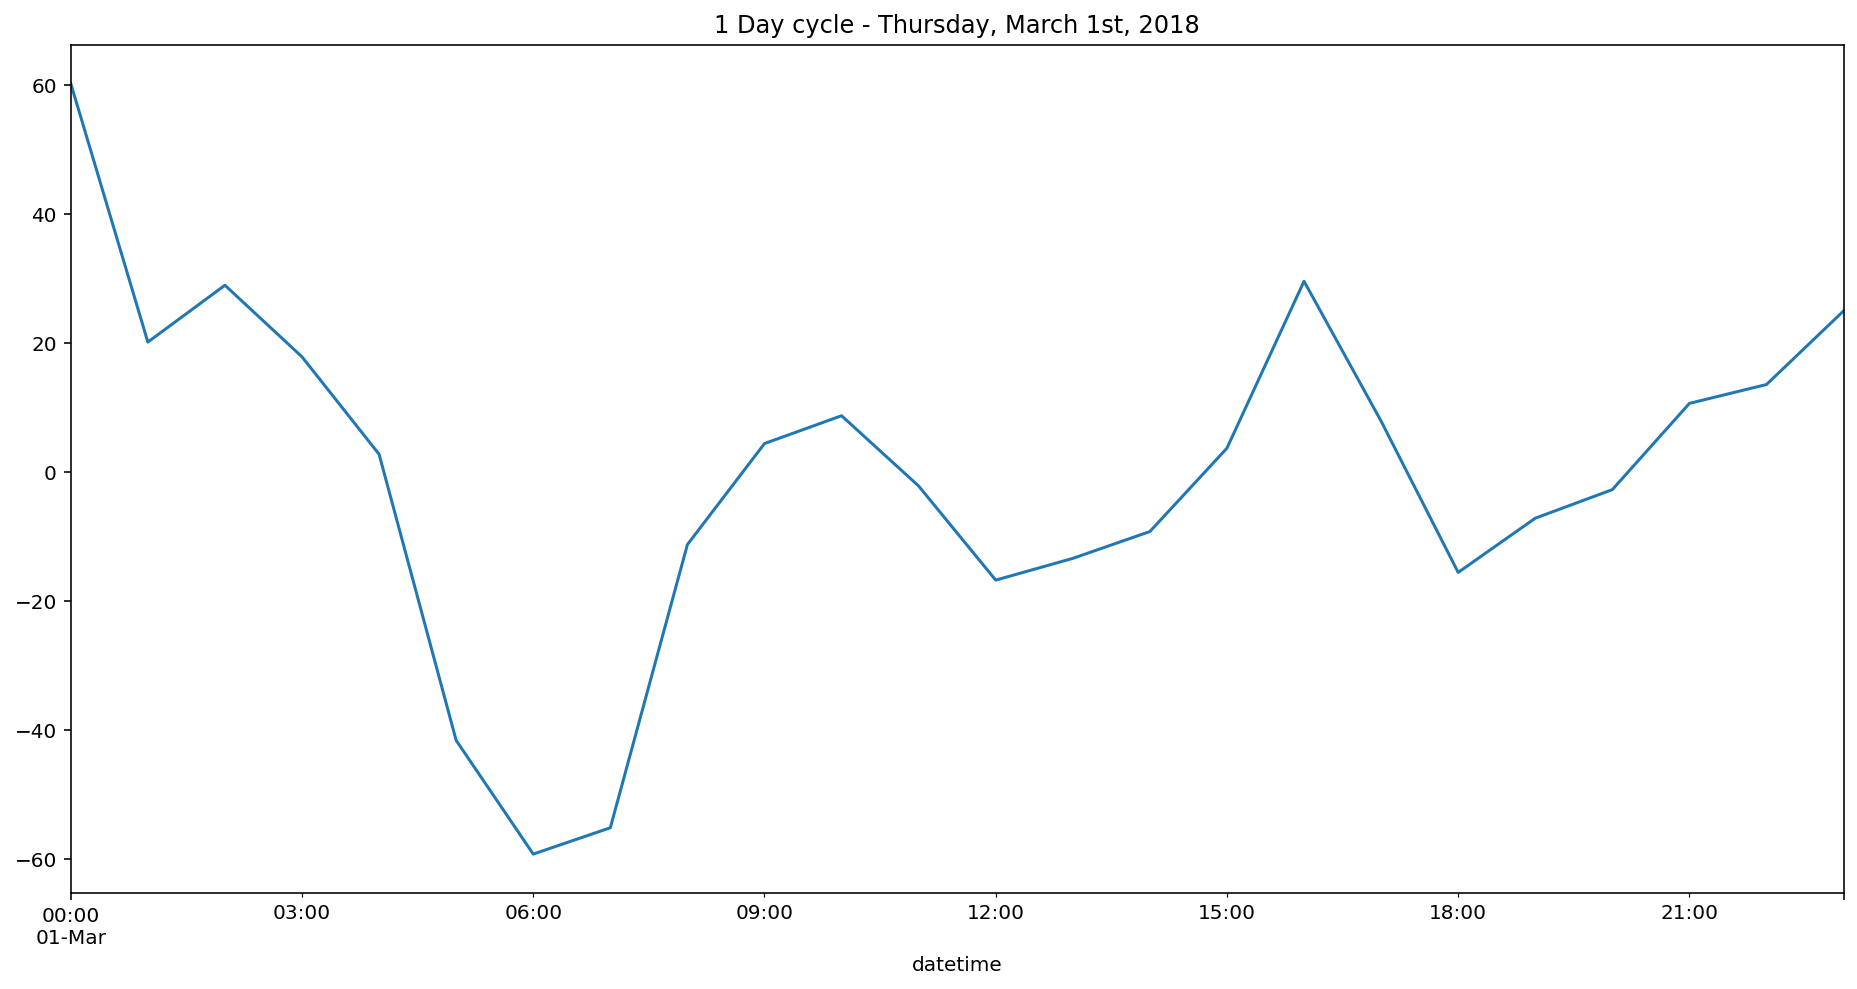

In [22]:
day_res = seasonal_decompose(df.resample('1H').sum()).seasonal['2018-03-01']
day_res.plot(title='1 Day cycle - {}, March 1st, 2018'.format(day_res.index[0].date().strftime('%A')))
plt.tight_layout();

Most orders are at midnight, decreasing to the lowest point at 06:00,  
with another peak at around 16:00, and then steadily increasing from 18:00.

### Conclusions <a id='Analysis-conclusions'></a>

A general trend of growth was detected.  
Also noticed weekly and daily cycles.

Highest amount of orders is on Fridays and Mondays from a week perspective,  
and from a daily perspective it's from 12:00 to 16:00, and from 18:00 to 00:00.

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
It's nice that you tried to look for trends and seasonality at various levels, but it would be better if instead of looking at a small slice of data and decomposing it, you decomoposed the whole dataset, and looked at a small slice of the decomposition. The reason is that making conclusions about intra-month seasonality (for example, same applies to week and day analysis) based on one month of data is a bit far-fetched. It would be much more convincing if we took at a big timeframe including many months.
	  
</div>

<div class="alert alert-info">
<b>Student's comment v.1:</b>
    
  I've tried to implement it how you've suggested, but I think I haven't correctly captured the hourly resolution seasonality for different days  
    (weekdays vs. weekends, expected the hourly workload to look different - not sure how to capture it with the decomposition function).
    
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
Hmm, yeah, I'm not sure how to capture that either. In any case, keep in mind that this is a pretty crude method, just for getting a first approximation (see e.g. notes at the bottom of this function's [documentation page](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html))
	  
</div>

## Forecast

The resolution we want for the forecasting is of 1 hour, so we will resample the data appropriately.

In [23]:
df = df.resample('1H').sum()

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The data was resampled correctly
	  
</div>

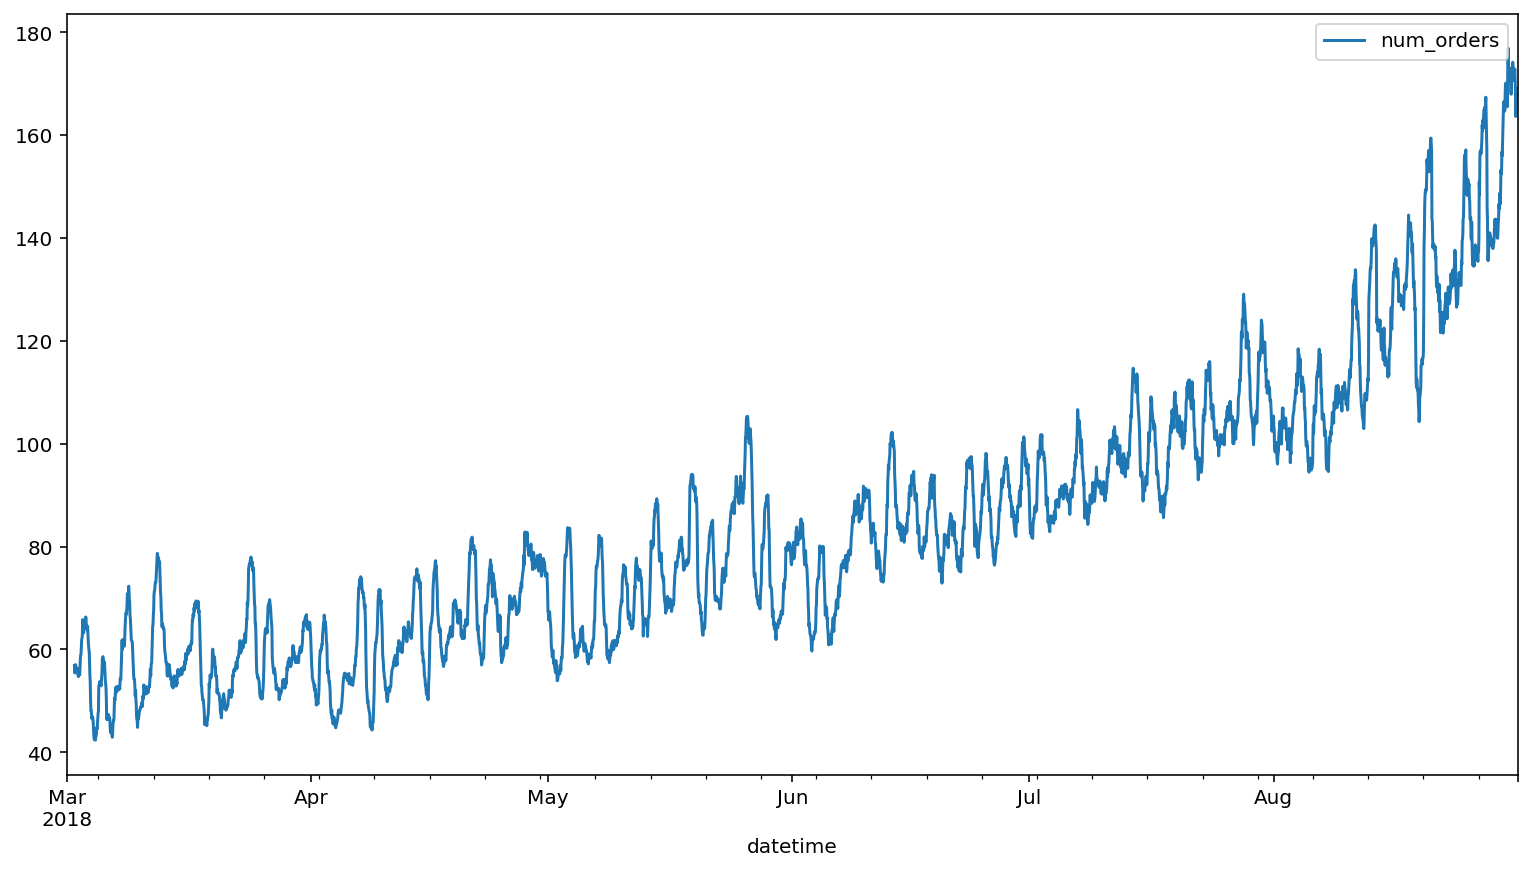

In [24]:
df.rolling(24).mean().plot();

In [25]:
def create_features(data, max_lag, rolling_mean_size):
    
    data = data.copy()
    
    # data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[data.columns[0]].shift(lag)

    data['rolling_mean'] = data[data.columns[0]].shift().rolling(rolling_mean_size).mean()
    
    return data.dropna()

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Features look good! You added calendar features, lag features and a correctly shifted rolling mean
	  
</div>

In [26]:
def split_X_y(data, target):
    return data.drop(target, axis=1), data[target]

In [27]:
def data_for_model(df, target, max_lag, rolling_mean_size, test_size=0.1):
    
    out = create_features(df, max_lag, rolling_mean_size)
    train, test = train_test_split(out, shuffle=False, test_size=test_size)
    X_train, y_train = split_X_y(data=train, target=target)
    X_test, y_test = split_X_y(data=test, target=target)
    
    return X_train, X_test, y_train, y_test

In [28]:
def scores(y_true, y_pred):
    return dict(rmse=np.sqrt(mean_squared_error(y_true, y_pred)), 
                mae=mean_absolute_error(y_true, y_pred), 
                r2=r2_score(y_true, y_pred))

In [29]:
def fit_predict(model, df, target,
                max_lag=10, 
                rolling_mean_size=10, 
                test_size=0.1,
                scoring='neg_mean_squared_error', 
                cv=5,
                params={}, 
                verbose=1):
    
    if verbose:
        print(model.__class__.__name__, '\n')
        
    X_train, X_test, y_train, y_test = data_for_model(df, target, max_lag, rolling_mean_size, test_size)
        
    pipeline = Pipeline([
        ('std_scale', StandardScaler()),
        # ('min_max_scale', MinMaxScaler()),
        ('model', model)
    ])

    if verbose > 1:
        display(X_train, pd.DataFrame(pipeline[0].fit_transform(X_train)))

    results = {}
        
    if params:
        params = {(k if k.startswith('model__') else 'model__'+k):v for k,v in params.items()}
        search = HalvingGridSearchCV(pipeline, params, 
                                     scoring=scoring,
                                     cv=TimeSeriesSplit(n_splits=cv),
                                     n_jobs=-2, random_state=random_state)
        
        search.fit(X_train, y_train)
        
        results['params'] = {(k.split('__')[1] if k.startswith('model__') else k):v 
                             for k,v in search.best_params_.items()}
        
        results['estimator'] = search.best_estimator_[-1]
        
        if verbose:
            print('best params')
            pprint(results['params'], width=1)
            print()
            
        pipeline.fit(X_train, y_train)
        y_train_pred = pipeline.predict(X_train)
        train_scores = scores(y_train, y_train_pred)
    else:
        pipeline.fit(X_train, y_train)
        cv = cross_validate(pipeline, X_train, y_train, 
                            scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                            cv=TimeSeriesSplit(n_splits=cv), 
                            n_jobs=-2)
        
        train_scores = dict(rmse=np.abs(cv['test_neg_root_mean_squared_error'].mean()),
                            mae=np.abs(cv['test_neg_mean_absolute_error'].mean()),
                            r2=np.abs(cv['test_r2'].mean()))
        
    y_test_pred = pipeline.predict(X_test)
    
    results['scores'] = pd.DataFrame({'train': train_scores,
                                      'test': scores(y_test, y_test_pred)}).T
    
    if verbose:
        display(results['scores'].round(2).style.format('{:.2f}'))
    
    return results

In [ ]:
def tune_lag_rolling(model, df, target, lag_space, rolling_space, cv=2, test_size=0.1):
    
    params = {}
    best_scores = None
    
    for lag in range(*lag_space):
        for window in range(*rolling_space):
            results = fit_predict(model, df, target, 
                                  max_lag=lag, rolling_mean_size=window, 
                                  cv=cv,
                                  test_size=test_size, verbose=0)
            
            # scores = results['scores'].loc['test'] # kept as reference for comment below
            scores = results['scores'].loc['train']
            
            if best_scores is None or scores['rmse'] < best_scores['rmse']:
                best_scores = scores
                params = results['params'].copy() if results.get('params') else {}
                params['lag'] = lag
                params['rolling_mean_window'] = window
                
    print('best params')
    pprint(params, width=1)
    print()
                
    print('scores')
    display(results['scores'].round(2).style.format('{:.2f}'))

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>
	  
A couple of problems here:
 
1. While I welcome your tuning of the number of lag features and the size of rolling window, we need to keep in mind that they are hyperparameters of the model. Tuning them on the test set is problematic, for the same reason as always: it is biasing the model towards better performance on this particular test set, and that leads to an overly optimistic estimate of the model's generalization performance and disappointing results when the model rolls out in production. So, you either need to split the data into train, validation and test, and tune these hyperparameters using the validation set or use some kind of cross-validation that is appropriate for time series (e.g. [TimeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split), an object of `TimeSeriesSplit` can be passed as a `cv` parameter to `GridSearchCV` and other similar functions).
2. Now when you're using `HalvingGridSearchCV` with regular k-fold cross-validation, there is a problem with looking ahead in every fold but one (compare illustrations for k-fold cross-validation and time series split on the page linked above)
	  
</div>

<div class="alert alert-info">
<b>Student's comment v.1:</b>
    
  Updated tune_lag_rolling to compare by train score,  
  and cv=TimeSeriesSplit (both with GridSearch and without).
    
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
Awesome! I think you've meant by cross-validation score on train, which is pretty different from just train score though :)
	  
</div>

In [31]:
new_df = create_features(df.copy(), 10, 10)

In [32]:
new_df.info()
new_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4406 entries, 2018-03-01 10:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4406 non-null   int64  
 1   month         4406 non-null   int64  
 2   day           4406 non-null   int64  
 3   dayofweek     4406 non-null   int64  
 4   hour          4406 non-null   int64  
 5   lag_1         4406 non-null   float64
 6   lag_2         4406 non-null   float64
 7   lag_3         4406 non-null   float64
 8   lag_4         4406 non-null   float64
 9   lag_5         4406 non-null   float64
 10  lag_6         4406 non-null   float64
 11  lag_7         4406 non-null   float64
 12  lag_8         4406 non-null   float64
 13  lag_9         4406 non-null   float64
 14  lag_10        4406 non-null   float64
 15  rolling_mean  4406 non-null   float64
dtypes: float64(11), int64(5)
memory usage: 585.2 KB


,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1


In [33]:
train, test = train_test_split(new_df, shuffle=False, test_size=0.1)

In [34]:
new_df.index.to_series().describe(datetime_is_numeric=True)

count                             4406
mean     2018-06-01 04:29:59.999999744
min                2018-03-01 10:00:00
25%                2018-04-16 07:15:00
50%                2018-06-01 04:30:00
75%                2018-07-17 01:45:00
max                2018-08-31 23:00:00
Name: datetime, dtype: object

In [35]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 10:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


The indices match, the data has been split successfully.

In [36]:
X_train, y_train = split_X_y(data=train, target='num_orders')
X_train.shape, y_train.shape

((3965, 15), (3965,))

In [37]:
X_test, y_test = split_X_y(data=test, target='num_orders')
X_test.shape, y_test.shape

((441, 15), (441,))

In [38]:
X_test.shape[0] / (X_test.shape[0] + X_train.shape[0])

0.10009078529278256

### Baseline

In [39]:
print('Median hourly orders:', np.median(y_test))

Median hourly orders: 135.0


In [40]:
for s in ["mean", "median"]:
    print(f'dummy strategy: {s}')
    display(fit_predict(DummyRegressor(strategy=s), df, 'num_orders', verbose=0)['scores'])
    print()

dummy strategy: mean


,rmse,mae,r2
train,40.479401,31.097024,0.315345
test,84.781307,68.403414,-1.093987



dummy strategy: median


,rmse,mae,r2
train,41.598175,32.102727,0.389880
test,87.242059,70.891156,-1.217305


In [41]:
pred_median = np.ones(test.shape[0]) * np.median(y_train)

In [42]:
pd.Series(scores(y_test, pred_median), name='constant median').round(2)

rmse    87.24
mae     70.89
r2      -1.22
Name: constant median, dtype: float64

In [43]:
pred_previous = y_test.shift(fill_value=y_train[0]).astype('float')

In [44]:
pd.Series(scores(y_test, pred_previous), name='adjacent entries diff').round(2)

rmse    59.05
mae     45.12
r2      -0.02
Name: adjacent entries diff, dtype: float64

The 'adjacent entries diff' method gives us the best baseline (RMSE=59.05).

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Yeah, previous value is often a decent baseline in time series models
	  
</div>

## Models - Preliminary run

In [45]:
fit_predict(LinearRegression(n_jobs=-2), df, 'num_orders');

LinearRegression 



,rmse,mae,r2
train,31.52,24.51,0.20
test,53.49,40.67,0.17


First model is already doing better than baseline.

In [46]:
fit_predict(RandomForestRegressor(n_jobs=-2, random_state=random_state), df, 'num_orders');

RandomForestRegressor 



,rmse,mae,r2
train,25.35,18.76,0.48
test,45.00,33.53,0.41


In [47]:
fit_predict(GradientBoostingRegressor(random_state=random_state), df, 'num_orders');

GradientBoostingRegressor 



,rmse,mae,r2
train,25.88,19.32,0.46
test,46.11,34.66,0.38


In [48]:
fit_predict(SVR(), df, 'num_orders');

SVR 



,rmse,mae,r2
train,35.54,26.65,0.01
test,74.84,57.63,-0.63


In [49]:
fit_predict(KNeighborsRegressor(n_jobs=-2), df, 'num_orders');

KNeighborsRegressor 



,rmse,mae,r2
train,28.69,21.32,0.33
test,55.13,40.92,0.11


In [50]:
fit_predict(XGBRegressor(n_jobs=-2, random_state=random_state), df, 'num_orders');

XGBRegressor 



,rmse,mae,r2
train,26.49,19.67,0.43
test,45.49,33.98,0.40


In [51]:
fit_predict(LGBMRegressor(n_jobs=-2, random_state=random_state), df, 'num_orders');

LGBMRegressor 



,rmse,mae,r2
train,25.24,18.77,0.48
test,42.14,31.16,0.48


In [52]:
fit_predict(CatBoostRegressor(silent=True, random_seed=random_state), df, 'num_orders');

CatBoostRegressor 



,rmse,mae,r2
train,25.02,18.68,0.49
test,43.25,32.60,0.46


Even without further tuning of the hyperparameters,  
we have several models which are doing better than our intended threshold of RMSE 48.

## Hyperparameters tuning

Further tuning of propspective models below.

### Linear Regression

In [53]:
%%time
tune_lag_rolling(LinearRegression(n_jobs=-2), df, 'num_orders',
                 lag_space=(10, 30), rolling_space=(10, 30))

best params
{'lag': 25,
 'rolling_mean_window': 28}

scores


,rmse,mae,r2
train,27.81,21.35,0.43
test,46.82,34.43,0.36


CPU times: user 1min 14s, sys: 11.7 s, total: 1min 26s
Wall time: 16.5 s


### Random Forest

In [54]:
%%time
rf_model = fit_predict(RandomForestRegressor(n_jobs=-2, random_state=random_state), df, 'num_orders', 
                       params={
                           'n_estimators': [90, 100, 120, 130, 150],
                           'max_depth': [None, 3, 5, 7, 10],
                       })['estimator']

RandomForestRegressor 

best params
{'max_depth': None,
 'n_estimators': 150}



,rmse,mae,r2
train,8.56,6.30,0.95
test,45.00,33.53,0.41


CPU times: user 10.4 s, sys: 344 ms, total: 10.8 s
Wall time: 14.3 s


In [55]:
%%time
tune_lag_rolling(rf_model, df, 'num_orders',
                 lag_space=(3, 30), rolling_space=(3, 15))

best params
{'lag': 24,
 'rolling_mean_window': 7}

scores


,rmse,mae,r2
train,27.51,20.39,0.45
test,43.31,32.28,0.46


CPU times: user 42min 33s, sys: 27.9 s, total: 43min 1s
Wall time: 9min 1s


In [56]:
%%time
fit_predict(rf_model, df, 'num_orders',
            max_lag=24, rolling_mean_size=8);

RandomForestRegressor 



,rmse,mae,r2
train,25.02,18.68,0.49
test,40.95,30.18,0.51


CPU times: user 11.2 s, sys: 106 ms, total: 11.3 s
Wall time: 3.82 s


### Gradient Boosting

In [57]:
%%time
gb_model = fit_predict(GradientBoostingRegressor(random_state=random_state), df, 'num_orders', 
                       params={
                           'learning_rate': [.3, .1, .01],
                           'n_estimators': [90, 100, 120, 130, 150],
                           'max_depth': [None, 3, 5, 7, 10],
                       })['estimator']

GradientBoostingRegressor 

best params
{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 150}



,rmse,mae,r2
train,20.13,15.47,0.73
test,46.11,34.66,0.38


CPU times: user 2.78 s, sys: 90.4 ms, total: 2.87 s
Wall time: 10.2 s


In [58]:
%%time
tune_lag_rolling(gb_model, df, 'num_orders', 
                 lag_space=(3, 30), rolling_space=(3, 15))

best params
{'lag': 24,
 'rolling_mean_window': 5}

scores


,rmse,mae,r2
train,28.00,20.77,0.43
test,42.37,32.01,0.48


CPU times: user 7min 35s, sys: 2.02 s, total: 7min 37s
Wall time: 12min 44s


In [59]:
fit_predict(gb_model, df, 'num_orders',
            max_lag=27, rolling_mean_size=11);

GradientBoostingRegressor 



,rmse,mae,r2
train,25.03,18.72,0.50
test,40.88,30.42,0.51


### XGB

In [60]:
%%time
tune_lag_rolling(XGBRegressor(n_jobs=-2, random_state=random_state), df, 'num_orders',
                 lag_space=(3, 30), rolling_space=(3, 15))

best params
{'lag': 24,
 'rolling_mean_window': 3}

scores


,rmse,mae,r2
train,29.77,21.88,0.35
test,45.69,33.68,0.39


CPU times: user 20min 56s, sys: 1min 6s, total: 22min 3s
Wall time: 5min 59s


In [71]:
fit_predict(XGBRegressor(n_jobs=-2, random_state=random_state), df, 'num_orders',
            max_lag=25, rolling_mean_size=4);

XGBRegressor 



,rmse,mae,r2
train,26.38,19.91,0.44
test,40.40,30.17,0.53


### LGBM

In [62]:
%%time
tune_lag_rolling(LGBMRegressor(n_jobs=-2, random_state=random_state), df, 'num_orders', 
                 lag_space=(3, 30), rolling_space=(3, 15))

best params
{'lag': 24,
 'rolling_mean_window': 3}

scores


,rmse,mae,r2
train,27.58,20.40,0.44
test,40.27,29.85,0.53


CPU times: user 9min 59s, sys: 59.6 s, total: 10min 59s
Wall time: 5min 25s


In [69]:
fit_predict(LGBMRegressor(n_jobs=-2, random_state=random_state), df, 'num_orders',
            max_lag=25, rolling_mean_size=5);

LGBMRegressor 



,rmse,mae,r2
train,24.96,18.79,0.50
test,39.16,28.52,0.55


### CatBoost

In [66]:
# takes forever. should consider using other methods, perhaps a bayesian optimization approach (scikit-opt).

# %%time
# tune_lag_rolling(CatBoostRegressor(silent=True, random_seed=random_state), df, 'num_orders', 
#                  lag_space=(3, 30), rolling_space=(3, 15))

In [67]:
fit_predict(CatBoostRegressor(silent=True, random_seed=random_state), df, 'num_orders', 
            max_lag=27, rolling_mean_size=7);

CatBoostRegressor 



Custom logger is already specified. Specify more than one logger at same time is not thread safe.

,rmse,mae,r2
train,24.13,18.01,0.53
test,38.59,28.70,0.57


### Conclusions <a id='Forecast-conclusions'></a>

CatBoost had the best results, with RMSE = 38.59 (baseline RMSE = 59.05).  
Since the median of hourly orders is 135, and our model's MAE is 28.7,  
we got a pretty good predicting model.

Even so, all of the models are overfit (worse test score than train score).  
Could try and counteract it by further tuning of other hyperparameters, regularization, etc..  
(preferably via utilizing advanced parallelization and GPU power).

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
Great, you used various different models, and achieved good results; although as noted in a comment above, they might be a bit overly optimistic due to tuning hyperparameters on the test set.
	  
</div>

<div class="alert alert-info">
<b>Student's comment v.1:</b>
    
  Even after updating, the results look pretty much the same (optimistic).  
  I've set cv=TimeSeriesSplit(n_splits=2) for tune_lag_rolling, and tune by the cv mean score.  
  Any insights?
    
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
I guess you were just lucky and didn't overfit to the test set, even when hyperparameters were tuned on the test set. But it doesn't mean that you'll get away with it every time, so I hope it's clear why following the correct procedure is important :)
	  
</div>